In [1]:
using Plots, Printf, DelimitedFiles, BenchmarkTools, DelimitedFiles, Serialization, Random
include("../src/MDToolbox.jl")
using .MDToolbox
ENV["COLUMNS"] = 130

130

In [2]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end
MDToolbox.decenter!(model_array)
config = AfmizeConfig(10.0 * (pi / 180), 
                      10, 
                      MDToolbox.Point2D(-250, -200), 
                      MDToolbox.Point2D(250, 200), 
                      MDToolbox.Point2D(6.25, 6.25), 
                      MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 10.0, Main.MDToolbox.Point2D{Int64}(-250, -200), Main.MDToolbox.Point2D{Int64}(250, 200), Main.MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))

  0.829324 seconds (2.92 M allocations: 128.769 MiB, 3.56% gc time)


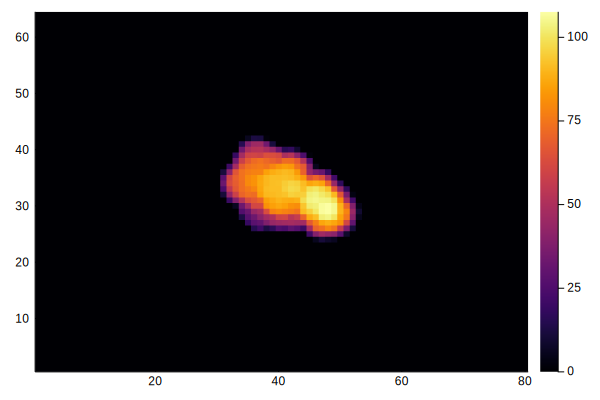

In [3]:
@time afm = MDToolbox.afmize(MDToolbox.rotate(model_array[1, :], q_array[1, :]), config);
heatmap(afm)

In [4]:
result = getafmposteriors_alpha([afm, afm], model_array[1:2, :], q_array[1:2, :], [config])

func is fft_convolution
model_id = 1
model_id = 2


2-element Array{Any,1}:
 Main.MDToolbox.posteriorResult([1, 1], [1, 1], [1.0; 0.0], (1, 1), 171906.51168148278, 1, 1, 1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])
 Main.MDToolbox.posteriorResult([1, 1], [1, 1], [1.0; 0.0], (1, 1), 171906.51168148278, 1, 1, 1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

[1, 1]
[1, 1]
[1.0; 0.0]
(1, 1)
171906.51168148278
1
1
1


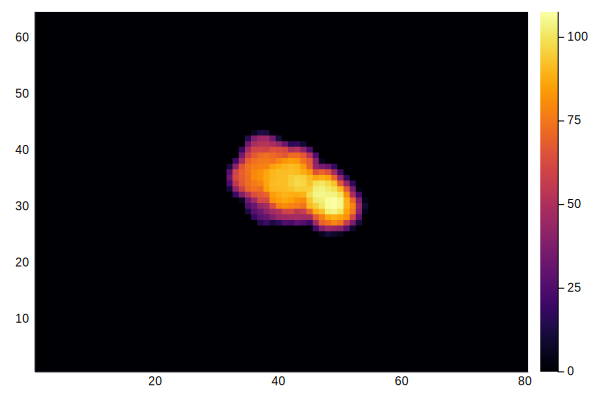

In [5]:
println(result[1].each_quate_id)
println(result[1].each_param_id)
println(result[1].posterior_results)
println(result[1].best_translate)
println(result[1].best_posterior)
println(result[1].best_model_id)
println(result[1].best_quate_id)
println(result[1].best_param_id)
heatmap(result[1].best_afm)

In [6]:
MDToolbox.outputResults(result, "tmp.txt")
result = MDToolbox.inputResults("tmp.txt")

2-element Array{Any,1}:
 Main.MDToolbox.posteriorResult([1, 1], [1, 1], [1.0, 0.0], (1, 1), 171906.51168148278, 1, 1, 1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])
 Main.MDToolbox.posteriorResult([1, 1], [1, 1], [1.0, 0.0], (1, 1), 171906.51168148278, 1, 1, 1, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

[1, 1]
[1, 1]
[1.0, 0.0]
(1, 1)
171906.51168148278
1
1
1


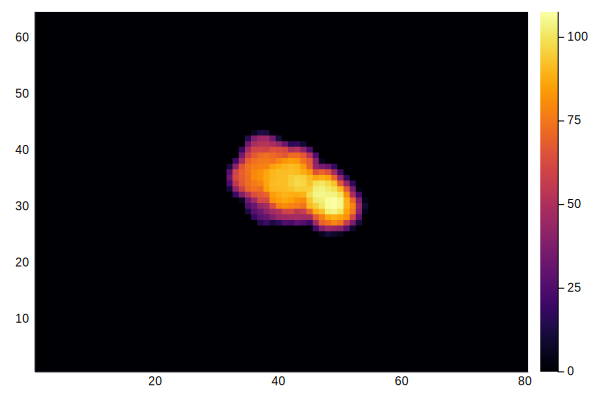

In [7]:
println(result[1].each_quate_id)
println(result[1].each_param_id)
println(result[1].posterior_results)
println(result[1].best_translate)
println(result[1].best_posterior)
println(result[1].best_model_id)
println(result[1].best_quate_id)
println(result[1].best_param_id)
heatmap(result[1].best_afm)

In [26]:
seed = MersenneTwister(0)

model_num = size(model_array)[1]
q_num = size(q_array)[1]
function make_rand_tada(seed, sigmam, num)
    ret = []
    for i in 1:num
        model = model_array[rand(seed, 1:model_num), :]
        radius = rand(seed, 10:30)
        quate = q_array[rand(seed, 1:q_num), :]
        dx = rand(seed, 1:25) * 0.25
        dy = rand(seed, 1:25) * 0.25
        config = AfmizeConfig(10.0 * (pi / 180), 
                      radius, 
                      MDToolbox.Point2D(-250 + dx, -200 + dy), 
                      MDToolbox.Point2D(250 + dx, 200 + dy), 
                      MDToolbox.Point2D(6.25, 6.25), 
                      MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        afm = MDToolbox.afmize(model, config)
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigmam
        push!(ret, afm)
    end
    return ret
end

make_rand_tada (generic function with 2 methods)

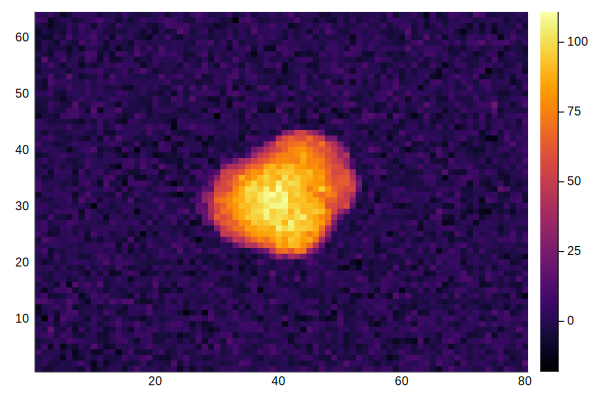

In [33]:
seed = MersenneTwister(0)
sigma = 5
heatmap(make_rand_tada(seed, sigma, 1)[1])